<a href="https://colab.research.google.com/github/cconsta1/PINNs_YouTube/blob/main/PINN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Comprehensive Poschl-Teller Analysis: Analytic, Harmonic Oscillator Basis, and PINN Solutions

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import lpmv, gamma, hermite, factorial
from scipy.integrate import simpson
from scipy.linalg import eigh
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# =============================================================================
# PART 1: ANALYTIC POSCHL-TELLER SOLUTIONS
# =============================================================================

# Physical parameters
lam = 8  # integer >= 1
V0 = 0.5 * lam * (lam + 1)

def V_PT(x):
    """Poschl-Teller potential"""
    return -V0 * (1/np.cosh(x))**2

def E_PT(mu):
    """Analytic eigenvalues"""
    return -0.5 * mu**2

def psi_PT(x, mu, lam):
    """Analytic normalized eigenfunctions"""
    norm = np.sqrt(mu * gamma(lam - mu + 1) / gamma(lam + mu + 1))
    return norm * lpmv(mu, lam, np.tanh(x))

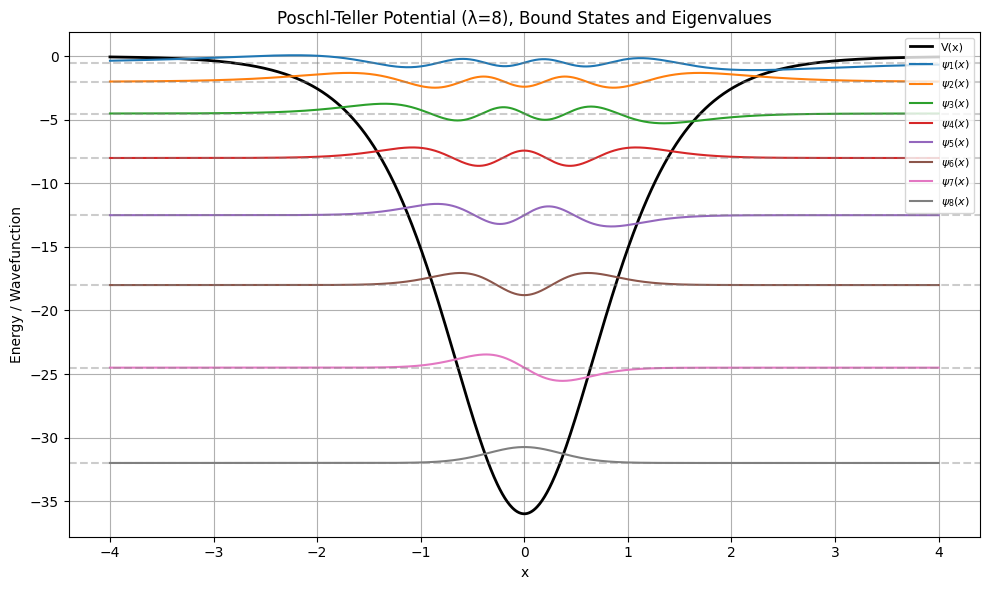

In [4]:
# Plot potential and bound states
x_plot = np.linspace(-4, 4, 1000)
plt.figure(figsize=(10,6))
plt.plot(x_plot, V_PT(x_plot), 'k-', lw=2, label='V(x)')
for mu in range(1, lam+1):
    psi = psi_PT(x_plot, mu, lam)
    plt.plot(x_plot, psi + E_PT(mu), label=fr"$\psi_{{{mu}}}(x)$")
    plt.axhline(E_PT(mu), linestyle='--', color='gray', alpha=0.4)
plt.xlabel('x')
plt.ylabel('Energy / Wavefunction')
plt.title(f'Poschl-Teller Potential (λ={lam}), Bound States and Eigenvalues')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Check orthonormality of analytic solutions
x_grid = np.linspace(-100, 100, 200000)

overlap_matrix = np.zeros((lam, lam))


for i in range(lam):
    for j in range(lam):
        psi1 = psi_PT(x_grid, i+1, lam)
        psi2 = psi_PT(x_grid, j+1, lam)
        overlap_matrix[i, j] = simpson(psi1 * psi2, x_grid)

print("Orthonormality matrix for analytic PT solutions:")
print(np.round(overlap_matrix, 4))

Orthonormality matrix for analytic PT solutions:
[[ 1. -0. -0. -0. -0. -0.  0. -0.]
 [-0.  1. -0. -0. -0. -0. -0.  0.]
 [-0. -0.  1.  0. -0.  0. -0.  0.]
 [-0. -0.  0.  1.  0. -0. -0. -0.]
 [-0. -0. -0.  0.  1. -0.  0.  0.]
 [-0. -0.  0. -0. -0.  1. -0.  0.]
 [ 0. -0. -0. -0.  0. -0.  1.  0.]
 [-0.  0.  0. -0.  0.  0.  0.  1.]]


In [6]:
# Verify Hamiltonian matrix in analytic basis is diagonal

dx = x_grid[1] - x_grid[0]
H_matrix = np.zeros((lam, lam))
for i in range(lam):
    psi1 = psi_PT(x_grid, i+1, lam)
    for j in range(lam):
        psi2 = psi_PT(x_grid, j+1, lam)
        psi2_ddx = np.gradient(np.gradient(psi2, dx), dx)
        integrand = psi1 * (-0.5 * psi2_ddx + V_PT(x_grid) * psi2)
        H_matrix[i, j] = simpson(integrand, x_grid)

mu_labels = [f"μ={i+1}" for i in range(lam)]
df_H_analytic = pd.DataFrame(np.round(H_matrix, 6), index=mu_labels, columns=mu_labels)
print("\nHamiltonian matrix in analytic basis (should be diagonal):")
df_H_analytic


Hamiltonian matrix in analytic basis (should be diagonal):


,μ=1,μ=2,μ=3,μ=4,μ=5,μ=6,μ=7,μ=8
μ=1,-0.500049,-0.000000,0.000069,0.000000,-0.000047,-0.000000,0.000014,0.000000
μ=2,-0.000000,-2.000087,0.000000,0.000089,0.000000,-0.000045,0.000000,0.000007
μ=3,0.000069,-0.000000,-4.500108,-0.000000,0.000088,0.000000,-0.000031,0.000000
μ=4,-0.000000,0.000089,-0.000000,-8.000110,-0.000000,0.000071,-0.000000,-0.000015
μ=5,-0.000047,0.000000,0.000088,-0.000000,-12.500094,-0.000000,0.000045,0.000000
μ=6,0.000000,-0.000045,-0.000000,0.000071,-0.000000,-18.000064,-0.000000,0.000019
μ=7,0.000014,-0.000000,-0.000031,0.000000,0.000045,-0.000000,-24.500031,-0.000000
μ=8,0.000000,0.000007,-0.000000,-0.000015,0.000000,0.000019,-0.000000,-32.000007


In [26]:
# =============================================================================
# PART 2: HARMONIC OSCILLATOR BASIS EXPANSION
# =============================================================================

# Harmonic oscillator parameters
omega = 1.0
m = 1.0
hbar = 1.0

def HO_potential(x, omega=omega, m=m):
    """Harmonic oscillator potential"""
    return 0.5 * m * omega**2 * x**2

def ho_basis(n, x, omega=omega, m=m, hbar=hbar):
    """Harmonic oscillator basis functions"""
    norm = (m*omega/np.pi/hbar)**0.25 / np.sqrt(2**n * factorial(n))
    xi = np.sqrt(m*omega/hbar) * x
    return norm * np.exp(-xi**2 / 2) * hermite(n)(xi)

def ho_eigenvalue(n, omega=omega, hbar=hbar):
    """Harmonic oscillator eigenvalues"""
    return hbar * omega * (n + 0.5)

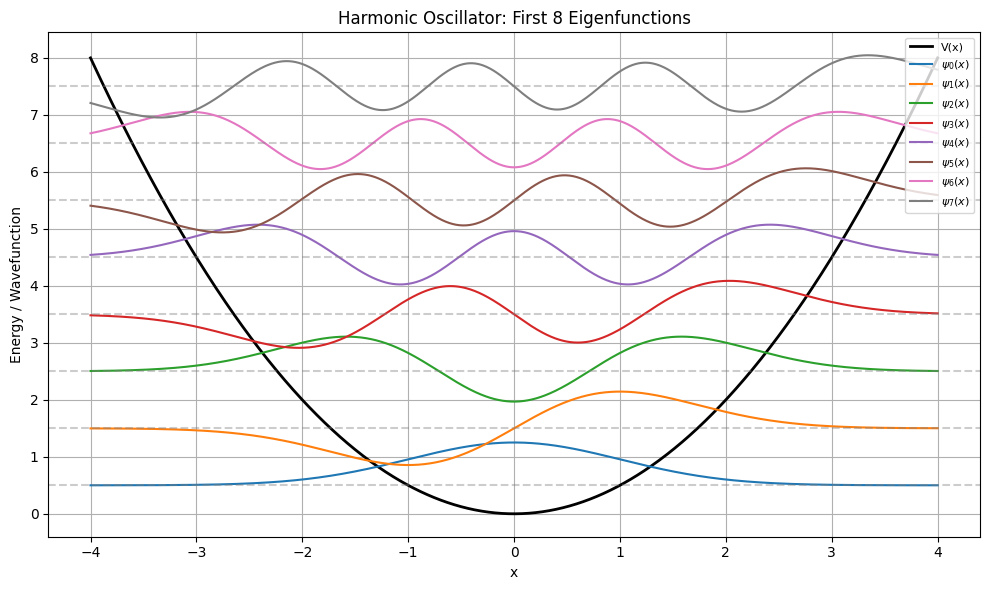

In [15]:
# Plot harmonic oscillator basis functions
plt.figure(figsize=(10,6))
plt.plot(x_plot, HO_potential(x_plot), 'k-', lw=2, label='V(x)')
for n in range(8):
    psi = ho_basis(n, x_plot)
    plt.plot(x_plot, psi + ho_eigenvalue(n), label=fr"$\psi_{{{n}}}(x)$")
    plt.axhline(ho_eigenvalue(n), linestyle='--', color='gray', alpha=0.4)
plt.xlabel('x')
plt.ylabel('Energy / Wavefunction')
plt.title('Harmonic Oscillator: First 8 Eigenfunctions')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Verify orthonormality of HO basis
x_grid_ho = np.linspace(-10, 10, 2000)
N_check = 8
ortho_matrix_ho = np.zeros((N_check, N_check))
for n in range(N_check):
    for m in range(N_check):
        ortho_matrix_ho[n, m] = simpson(ho_basis(n, x_grid_ho) * ho_basis(m, x_grid_ho), x_grid_ho)

df_ortho = pd.DataFrame(np.round(ortho_matrix_ho, 4),
                        index=[f"n={i}" for i in range(N_check)],
                        columns=[f"n={i}" for i in range(N_check)])
print("\nOrthonormality matrix for HO basis functions:")
df_ortho


Orthonormality matrix for HO basis functions:


,n=0,n=1,n=2,n=3,n=4,n=5,n=6,n=7
n=0,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
n=1,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0
n=2,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0
n=3,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0
n=4,-0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
n=5,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0
n=6,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0
n=7,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,1.0


In [24]:
# Calculate Poschl-Teller Hamiltonian matrix in HO basis
N_basis = 50
x_grid_basis = np.linspace(-8, 8, 2000)
dx_basis = x_grid_basis[1] - x_grid_basis[0]

H_ho = np.zeros((N_basis, N_basis))

for n in range(N_basis):
    psi_n = ho_basis(n, x_grid_basis)
    for m in range(N_basis):
        psi_m = ho_basis(m, x_grid_basis)
        psi_m_ddx = np.gradient(np.gradient(psi_m, dx_basis), dx_basis)

        integrand = psi_n * (-0.5 * psi_m_ddx + V_PT(x_grid_basis) * psi_m)

        H_ho[n, m] = simpson(integrand, x_grid_basis)

df_H_ho = pd.DataFrame(np.round(H_ho[:12,:12], 6),
                       index=[f"n={i}" for i in range(12)],
                       columns=[f"n={i}" for i in range(12)])
print("\nPoschl-Teller Hamiltonian matrix in HO basis (first 12x12 block):")

df_H_ho


Poschl-Teller Hamiltonian matrix in HO basis (first 12x12 block):


,n=0,n=1,n=2,n=3,n=4,n=5,n=6,n=7,n=8,n=9,n=10,n=11
n=0,-31.859125,0.000000,-1.409313,-0.000000,-0.203680,0.000000,0.024484,-0.000000,-0.003527,0.000000,0.000582,-0.000000
n=1,0.000000,-23.858599,-0.000000,-2.843133,0.000000,-0.395467,0.000000,0.054804,-0.000000,-0.008739,0.000000,0.001559
n=2,-1.409313,-0.000000,-16.356984,-0.000000,-4.494672,0.000000,-0.599751,-0.000000,0.093563,0.000000,-0.016296,0.000000
n=3,-0.000000,-2.843133,-0.000000,-9.244781,0.000000,-6.318337,-0.000000,-0.808090,-0.000000,0.139439,0.000000,-0.026247
n=4,-0.203680,0.000000,-4.494672,0.000000,-2.442000,0.000000,-8.276277,-0.000000,-1.014676,-0.000000,0.191058,0.000000
n=5,-0.000000,-0.395467,0.000000,-6.318337,0.000000,4.111089,0.000000,-10.339507,-0.000000,-1.215844,0.000000,0.247160
n=6,0.024484,-0.000000,-0.599751,-0.000000,-8.276277,0.000000,10.459928,-0.000000,-12.485921,-0.000000,-1.409394,-0.000000
n=7,0.000000,0.054804,-0.000000,-0.808090,-0.000000,-10.339507,0.000000,16.639664,0.000000,-14.698524,-0.000000,-1.594098
n=8,-0.003527,-0.000000,0.093563,-0.000000,-1.014676,0.000000,-12.485921,0.000000,22.677871,-0.000000,-16.964127,-0.000000
n=9,0.000000,-0.008739,-0.000000,0.139439,0.000000,-1.215844,-0.000000,-14.698524,-0.000000,28.596466,-0.000000,-19.272394



First few eigenvalues from HO basis diagonalization:
State 0: Numerical = -32.000474, Analytic = -32.000000, Error = 0.000474
State 1: Numerical = -24.501979, Analytic = -24.500000, Error = 0.001979
State 2: Numerical = -18.004106, Analytic = -18.000000, Error = 0.004106
State 3: Numerical = -12.506001, Analytic = -12.500000, Error = 0.006001
State 4: Numerical = -8.007057, Analytic = -8.000000, Error = 0.007057


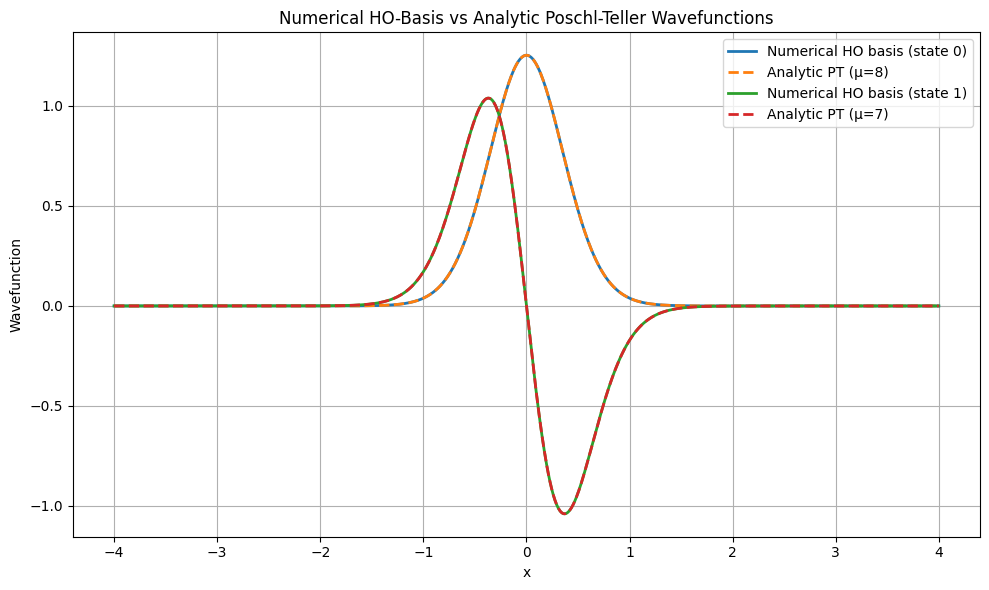

In [25]:
# Diagonalize to find PT eigenstates in HO basis
evals_ho, evecs_ho = eigh(H_ho)

print(f"\nFirst few eigenvalues from HO basis diagonalization:")
for i in range(min(5, len(evals_ho))):
    analytic_energy = E_PT(lam - i)
    print(f"State {i}: Numerical = {evals_ho[i]:.6f}, Analytic = {analytic_energy:.6f}, Error = {abs(evals_ho[i] - analytic_energy):.6f}")

# Compare numerical HO-basis solutions with analytic PT solutions
plt.figure(figsize=(10,6))
for idx in range(2):
    # Construct numerical wavefunction from HO basis expansion
    psi_numerical = np.zeros_like(x_plot)
    for n in range(N_basis):
        psi_numerical += evecs_ho[n, idx] * ho_basis(n, x_plot)


    plt.plot(x_plot, psi_numerical, label=f'Numerical HO basis (state {idx})', lw=2)
    plt.plot(x_plot, psi_PT(x_plot, lam-idx, lam), '--',
             label=f'Analytic PT (μ={lam-idx})', lw=2)

plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.title('Numerical HO-Basis vs Analytic Poschl-Teller Wavefunctions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# =============================================================================
# PART 3: PHYSICS-INFORMED NEURAL NETWORK (PINN) SOLUTION
# =============================================================================

# PINN configuration
class PINNConfig:
    WIDTH = 50
    DEPTH = 6
    N_TRAIN_POINTS = 40
    X_TRAIN_RANGE = (-5, 5)
    N_PHYS_POINTS = 800
    X_PHYS_RANGE = (-8, 8)
    LEARNING_RATE = 1e-3
    N_EPOCHS = 10000
    E_INITIAL_GUESS = -0.5 * lam**2 + 2.0
    WEIGHT_DATA = 1.0
    WEIGHT_PHYS = 2.0
    SCHEDULER_GAMMA = 0.99
    SCHEDULER_STEP_START = 2000

cfg = PINNConfig()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


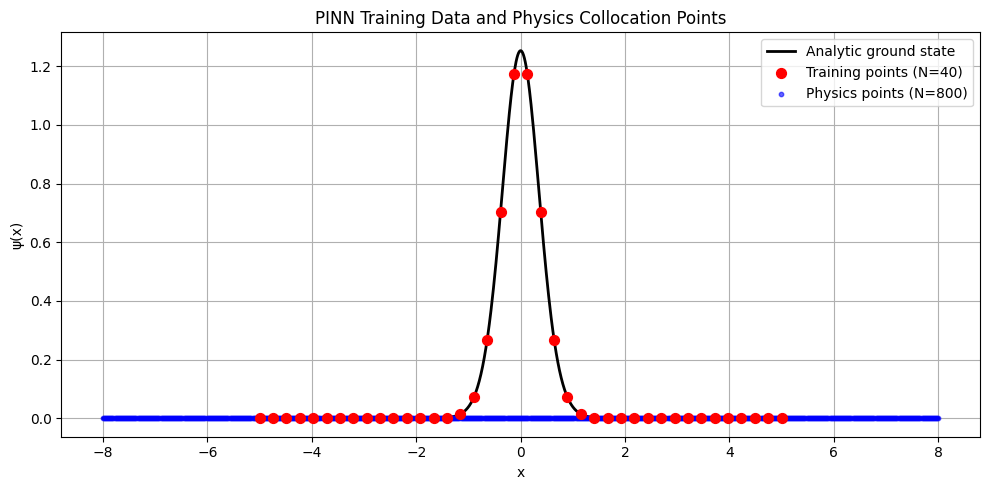

In [28]:
# Prepare training data from analytic ground state
x_grid_fine = np.linspace(-8, 8, 1000)
psi_gs_analytic = psi_PT(x_grid_fine, lam, lam)

x_train = np.linspace(cfg.X_TRAIN_RANGE[0], cfg.X_TRAIN_RANGE[1], cfg.N_TRAIN_POINTS)
psi_train = np.interp(x_train, x_grid_fine, psi_gs_analytic)
x_train_torch = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32, device=device)
psi_train_torch = torch.tensor(psi_train.reshape(-1, 1), dtype=torch.float32, device=device)

x_phys = torch.linspace(cfg.X_PHYS_RANGE[0], cfg.X_PHYS_RANGE[1], cfg.N_PHYS_POINTS, device=device).reshape(-1, 1).requires_grad_()

# Plot the training data points and physics collocation points used for PINN
plt.figure(figsize=(10, 5))
plt.plot(x_grid_fine, psi_gs_analytic, 'k-', label='Analytic ground state', lw=2)
plt.scatter(x_train, psi_train, color='red', s=50, zorder=5, label=f'Training points (N={cfg.N_TRAIN_POINTS})')
plt.scatter(x_phys.detach().cpu().numpy(), np.zeros(cfg.N_PHYS_POINTS), color='blue', s=10, alpha=0.6, zorder=4, label=f'Physics points (N={cfg.N_PHYS_POINTS})')
plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.title('PINN Training Data and Physics Collocation Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Define PINN model
class PINN(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers.extend([nn.Linear(width, width), nn.Tanh()])
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = PINN(width=cfg.WIDTH, depth=cfg.DEPTH).to(device)
E_pinn = torch.tensor([cfg.E_INITIAL_GUESS], requires_grad=True, device=device)

# Define potential and Schrodinger equation residual
V_PT_torch = lambda x: -V0 * torch.pow(1 / torch.cosh(x), 2)

def schrodinger_residual(x, nn_model, V_func, E_tensor):
    """Calculate residual of time-independent Schrodinger equation"""
    psi = nn_model(x)
    psi_x = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_xx = torch.autograd.grad(psi_x, x, grad_outputs=torch.ones_like(psi_x), create_graph=True)[0]
    Vx = V_func(x)
    return -0.5 * psi_xx + (Vx - E_tensor) * psi

In [31]:
# Training setup
params = list(model.parameters()) + [E_pinn]
optimizer = optim.Adam(params, lr=cfg.LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=cfg.SCHEDULER_GAMMA)

print("Starting PINN training...")
for epoch in range(cfg.N_EPOCHS):
    optimizer.zero_grad()

    # Data loss term
    psi_pred = model(x_train_torch)
    loss_data = torch.mean((psi_pred - psi_train_torch)**2)

    # Physics loss term
    residual = schrodinger_residual(x_phys, model, V_PT_torch, E_pinn)
    loss_phys = torch.mean(residual**2)

    # Combined loss
    loss = (cfg.WEIGHT_DATA * loss_data) + (cfg.WEIGHT_PHYS * loss_phys)

    loss.backward()
    optimizer.step()

    if epoch > cfg.SCHEDULER_STEP_START and epoch % 500 == 0:
        scheduler.step()

    if epoch % 1000 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}: Total={loss.item():.4g}, Data={loss_data.item():.4g}, "
              f"Phys={loss_phys.item():.4g}, E_pinn={E_pinn.item():.6f}, LR={lr:.2e}")

Starting PINN training...
Epoch 0: Total=0.6384, Data=0.09494, Phys=0.2717, E_pinn=-29.999001, LR=1.00e-03
Epoch 1000: Total=0.09601, Data=0.09545, Phys=0.0002804, E_pinn=-29.966745, LR=1.00e-03
Epoch 2000: Total=0.1383, Data=0.07898, Phys=0.02964, E_pinn=-30.206049, LR=1.00e-03
Epoch 3000: Total=0.09666, Data=0.09574, Phys=0.0004578, E_pinn=-30.700703, LR=9.80e-04
Epoch 4000: Total=0.08658, Data=0.08582, Phys=0.0003793, E_pinn=-31.151239, LR=9.61e-04
Epoch 5000: Total=0.04116, Data=0.03529, Phys=0.002936, E_pinn=-31.595213, LR=9.41e-04
Epoch 6000: Total=0.0455, Data=0.04372, Phys=0.0008922, E_pinn=-31.833368, LR=9.23e-04
Epoch 7000: Total=0.03505, Data=0.03324, Phys=0.0009035, E_pinn=-31.954401, LR=9.04e-04
Epoch 8000: Total=0.008033, Data=0.006464, Phys=0.0007841, E_pinn=-31.996565, LR=8.86e-04
Epoch 9000: Total=0.001502, Data=0.0004785, Phys=0.0005119, E_pinn=-31.999857, LR=8.69e-04



--- PINN Results ---
Final PINN Energy: -31.992054
Analytic Ground State Energy: -32.000000
Error in Energy: 0.007946


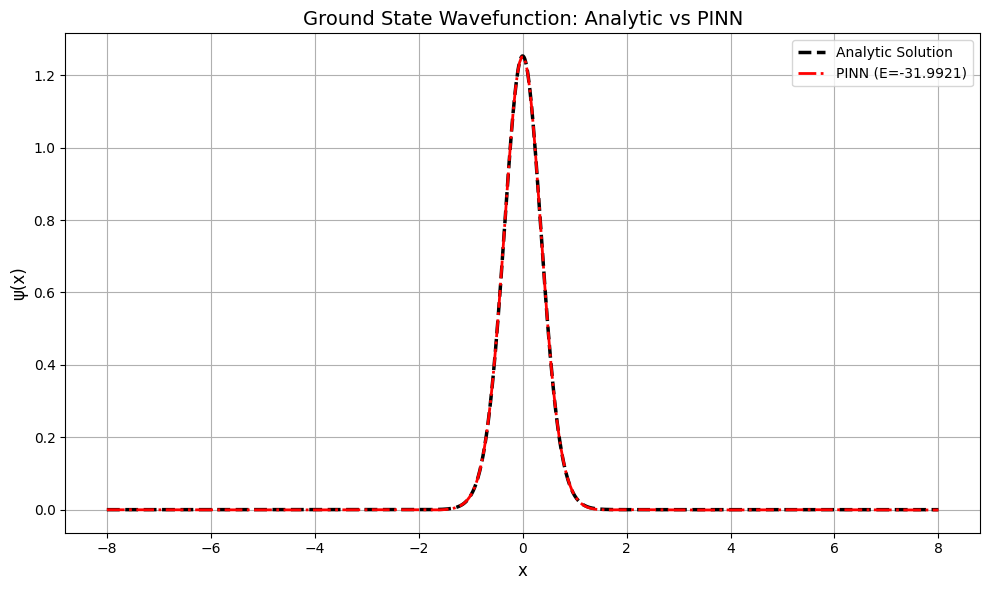

In [32]:
# Evaluate PINN results
print("\n--- PINN Results ---")
print(f"Final PINN Energy: {E_pinn.item():.6f}")
print(f"Analytic Ground State Energy: {E_PT(lam):.6f}")
print(f"Error in Energy: {abs(E_pinn.item() - E_PT(lam)):.6f}")

# Generate and normalize PINN wavefunction
x_eval = np.linspace(-8, 8, 400)
x_eval_torch = torch.tensor(x_eval.reshape(-1, 1), dtype=torch.float32, device=device)
with torch.no_grad():
    psi_pinn_raw = model(x_eval_torch).cpu().numpy().flatten()

psi_pinn = psi_pinn_raw / np.sqrt(simpson(psi_pinn_raw**2, x_eval))
if psi_pinn[len(x_eval)//2] < 0:
    psi_pinn *= -1

# Final comparison plot
plt.figure(figsize=(10, 6))
plt.plot(x_grid_fine, psi_gs_analytic, 'k--', label="Analytic Solution", lw=2.5)
plt.plot(x_eval, psi_pinn, '-.', label=f"PINN (E={E_pinn.item():.4f})", lw=2, color='red')
plt.xlabel('x', fontsize=12)
plt.ylabel('ψ(x)', fontsize=12)
plt.title('Ground State Wavefunction: Analytic vs PINN', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()